# Models trained with Optuna

## Preparation of MLFlow and data set

In [5]:
# stuff for MLFlow
%matplotlib inline
import sys
sys.path.append('../modeling')
from config import TRACKING_URI
import mlflow

# set the experiment id
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.autolog()

# prepare the data
import pandas as pd
from sklearn.model_selection import train_test_split

SEED = 42

df = pd.read_csv('../data/synth_combined.csv', index_col=0)
col_target = 'dropped_out'
X = df.drop(col_target, axis=1)
# MLFlow doesn't like a series for the target, so convert it to numpy - for sklearn it doesn't matter
y = df[col_target].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

2025/06/04 21:12:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


## Logistic Regression

Logistic Regression isn't a good model for our data set. The f1-score is always ~ 0.628, the parameters don't matter. With parameter tuning the best parameters jump around erraticly, but the f1-score doesn't change.

[I 2025-06-04 17:40:26,878] A new study created in memory with name: no-name-a99c5415-9557-4d98-b7e8-ff2feb6fc49a


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-04 17:41:51,810] Trial 0 finished with value: 0.6072397509738361 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.1373945435333397, 'max_iter': 200, 'l1_ratio': 0.7929027006085794}. Best is trial 0 with value: 0.6072397509738361.
[I 2025-06-04 17:43:05,534] Trial 1 finished with value: 0.6072688803266626 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.14077101977634596, 'max_iter': 100}. Best is trial 1 with value: 0.6072688803266626.
[I 2025-06-04 17:44:34,223] Trial 2 finished with value: 0.607238019639377 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 0.9711044522321803, 'max_iter': 200, 'l1_ratio': 0.29228663909245417}. Best is trial 1 with value: 0.6072688803266626.
[I 2025-06-04 17:45:48,526] Trial 3 finished with value: 0.6072706842679249 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.31575714059323573, 'max_iter': 500}. Best is trial 3 with value: 0.6072706842679249.
[I 2025-06-04 17:47:04,044] Trial 4 finish

2025/06/04 17:56:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/boesi/Projekte/neue-fische/FinApprenticeship/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/04 17:56:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/boesi/

🏃 View run overjoyed-calf-437 at: http://mlflow.fa.berufsnavigator.de/#/experiments/783766249587513434/runs/946598f65ebd428d976d89b97eb7d500
🧪 View experiment at: http://mlflow.fa.berufsnavigator.de/#/experiments/783766249587513434


2025/06/04 17:56:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/boesi/Projekte/neue-fische/FinApprenticeship/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/06/04 17:56:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/boesi/

Pipeline(steps=[('enc_onehot', OneHotEncoder(drop='first')),
                ('model_logreg',
                 LogisticRegression(C=0.2545584342051509, max_iter=200,
                                    random_state=42))])

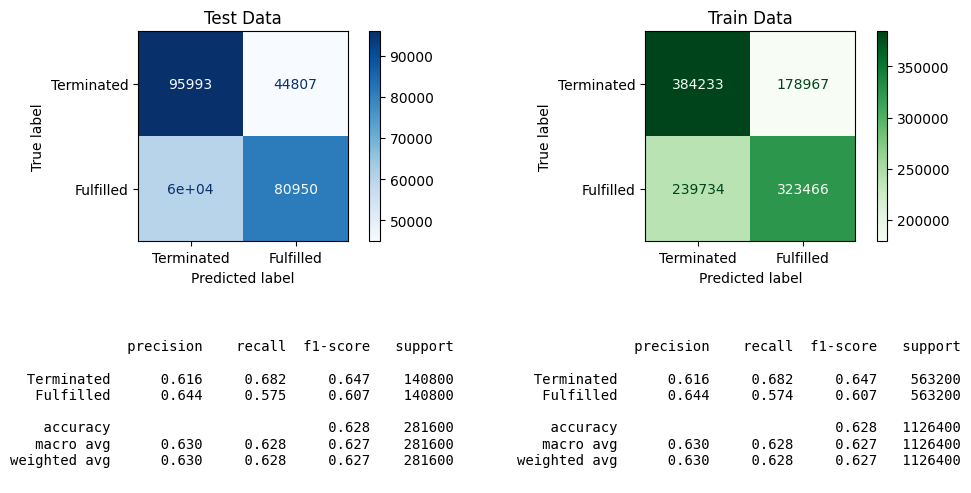

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

mlflow.set_experiment(experiment_name='model_optuna_logistic_regression')

def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])
    C = trial.suggest_float('C', 0.1, 1, log=True)
    max_iter = trial.suggest_categorical('max_iter', [100, 200, 500])
    l1_ratio = None
    # Only valid solver/penalty combos for sklearn
    valid_solver = {
        'l2': ['lbfgs', 'saga'],
        'elasticnet': ['saga']
    }
    if solver not in valid_solver[penalty]:
        raise optuna.TrialPruned()
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.2, 0.8)

    model = Pipeline([
        ('enc_onehot', OneHotEncoder(drop='first')),
        ('model_logreg', LogisticRegression(
            penalty=penalty,
            C=C,
            solver=solver,
            max_iter=max_iter,
            l1_ratio=l1_ratio,
            random_state=SEED,
        ))
    ])
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score


with mlflow.start_run() as run:
    study = optuna.create_study(direction='maximize')
    study.optimize(
        objective,
        n_trials=30,
        show_progress_bar=True,
    )

    best_params = study.best_trial.params
    mlflow.log_params(best_params)
    mlflow.log_metric('best_f1_score', study.best_value)

    # Fit the best model on the full training set
    best_model = Pipeline([
        ('enc_onehot', OneHotEncoder(drop='first')),
        ('model_logreg', LogisticRegression(
            penalty=best_params['penalty'],
            C=best_params['C'],
            solver=best_params['solver'],
            max_iter=best_params['max_iter'],
            l1_ratio=best_params.get('l1_ratio', None),
            random_state=SEED,
        ))
    ])
    best_model.fit(X_train, y_train)

from utils import check_classification_binary
check_classification_binary(best_model, X_train, X_test, y_train, y_test)
best_model

## KNN with simple matching

Simple Matching for categorical variables means the *distance* between two samples is the count (or proportion) of features where the values differ. For example, if two samples have 7 categorical features and 3 of them match, the simple matching distance is 4 (or 4/7 if normalized).

KMM is way too slow for this many samples. After 45 minutes not even one iternation of the tuning cycle was done. So we leave it here as an interesting experiment.

In [8]:
import optuna
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

mlflow.set_experiment(experiment_name='model_optuna_knn_simple_matching')

encoder = OrdinalEncoder()
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.fit_transform(X_test)

def simple_matching(x, y):
    return np.sum(x != y)

def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 5)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    # leaf_size = trial.suggest_int('leaf_size', 10, 10)
    leaf_size = 10

    model = KNeighborsClassifier(
        metric=simple_matching,
        algorithm='auto',
        n_neighbors=n_neighbors,
        weights=weights,
        leaf_size=leaf_size,
    )
    
    score = cross_val_score(model, X_train_enc, X_train_enc, cv=5, scoring='f1').mean()
    return score

with mlflow.start_run() as run:
    study = optuna.create_study(direction='maximize')
    study.optimize(
        objective,
        n_trials=30,
        show_progress_bar=True,
    )

    best_params = study.best_trial.params
    mlflow.log_params(best_params)
    mlflow.log_metric('best_f1_score', study.best_value)

    # Fit the best model on the full training set
    best_model = KNeighborsClassifier(
        n_neighbors=best_params['n_neighbors'],
        weights=best_params['weights'],
        metric=simple_matching,
        algorithm='auto',
        leaf_size=best_params['leaf_size'],
    )
    best_model.fit(X_train_enc, y_train)

from utils import check_classification_binary
check_classification_binary(best_model, X_train_enc, X_test_enc, y_train, y_test)
best_model


[I 2025-06-04 22:21:36,711] A new study created in memory with name: no-name-12e22b33-4ad8-43cc-aeba-af16ff32ed9a


  0%|          | 0/30 [00:00<?, ?it/s]

[W 2025-06-04 22:33:17,685] Trial 0 failed with parameters: {'n_neighbors': 3, 'weights': 'uniform'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/boesi/Projekte/neue-fische/FinApprenticeship/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1598939/1995844547.py", line 30, in objective
    score = cross_val_score(model, X_train_enc, X_train_enc, cv=5, scoring='f1').mean()
            ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/boesi/Projekte/neue-fische/FinApprenticeship/.venv/lib/python3.13/site-packages/mlflow/utils/autologging_utils/safety.py", line 483, in safe_patch_function
    patch_function(call_original, *args, **kwargs)
    ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/boesi/Projekte/neue-fische/FinApprenticeship/.venv/lib/python3.13/site-packages/mlflow/sklearn/__init__.py"

KeyboardInterrupt: 